In [1]:
import networkx as nx
import collections 
import numpy as np
from scipy.stats import cauchy
from sklearn.isotonic import IsotonicRegression  
import matplotlib
import matplotlib.pyplot as plt


In [68]:
#utility functions
def getSortedDegSeq(G):
    degSeq = sorted([d for n, d in G.degree()], reverse=False) #small to large degrees
    return degSeq

def getDegHis(G,maxDeg):
    degSeq = getSortedDegSeq(G)
    degreeCount = collections.Counter(degSeq)
    degHis = np.zeros(maxDeg+1)
    for deg in degreeCount:
        degHis[deg]=degreeCount[deg]    
    return degHis

def degSeqToDegHis(degSeq, maxDeg):
    #assume deg sequence could be non-integer and be bigger than maxDegree
    degHis = np.zeros(maxDeg+1)
    for deg in degSeq:
        #print(deg)
        deg = int(round(deg))
        if deg <= maxDeg:
            degHis[deg]= degHis[deg]+1
    return degHis
    
    
def pdfToCdf(pdf):
    cdf = np.zeros(len(pdf))
    cdf[0] = pdf[0]
    for i in range(1,len(pdf)):
         cdf[i] = cdf[i-1] + pdf[i]            
    return cdf

def cdfToPdf(cdf):
    pdf = np.zeros(len(cdf))
    pdf[0] = cdf[0]
    for i in range(1,len(pdf)):
         pdf[i] = cdf[i] - cdf[i-1]            
    return pdf
    

def difDegHis_L1(his1,his2):
    #assume the same length
    return sum(abs(his1 - his2))

def difDegHis_L2(his1,his2):
    return sum(np.square(his1-his2))



def plotHis(trueHis,noisyHis):
    plt.plot(trueHis,'-g', label='trueHis')
    plt.plot(noisyHis,'--r', label='noisyHis')
    plt.legend();
    plt.xscale('log')

    
    
def plotCum(trueHis,noisyHis):
    plt.plot(pdfToCdf(trueHis), '3b', label='trueCum')
    plt.plot(pdfToCdf(noisyHis), '2y', label='noisyCum')
    plt.legend();
    plt.xscale('log')

#DP basic functions
def lap(trueCounts, sens, epsilon):
    scale = 1.0* sens/epsilon
    noisyCounts = trueCounts + np.random.laplace(0.0, scale, len(trueCounts))
    return noisyCounts

def postprocessCdf(noisyCdf, totalCount):
    #apply isotonic regression
    ir = IsotonicRegression(y_min=0, y_max=totalCount, increasing=True)
    cdf= ir.fit_transform(X=range(len(noisyCdf)),y=noisyCdf)   
    return cdf

def postprocessPdf(noisyPdf, nodesNum):
    cdf = pdfToCdf(noisyPdf)
    cdf = postprocessCdf(cdf, nodesNum)
    pdf = cdfToPdf(cdf)
    return pdf


def extendHis(his,maxDeg):
    #his has a shortern length 
    hisExtended = np.zeros(maxDeg + 1)
    hisExtended[0:len(his)] = his
    return hisExtended


In [3]:
#Edge DP algorithms for degree distribution

#Hay et al. ICDM'09 (baseline)
def edgeDP_degHis_Lap(G, maxDeg, epsilon):
    degHis = getDegHis(G, maxDeg)
    sens = 4.0
    noisyDegHis = lap(degHis, sens, epsilon)
    noisyDegHis = postprocessPdf(noisyDegHis, len(G.nodes()))
    return noisyDegHis


#Hay et al. ICDM'09, Proserpio et al. WOSN'12 (wPINQ)
def edgeDP_degSeq_Lap(G, maxDeg, epsilon):
    degSeq = np.array(getSortedDegSeq(G))
    sens = 2.0
    #print(degSeq)
    noisyDegSeq = lap(degSeq, sens,epsilon)
    noisyDegSeq = postprocessCdf(noisyDegSeq, maxDeg)
    #print(noisyDegSeq)
    noisyDegHis = degSeqToDegHis(noisyDegSeq, maxDeg)
    return noisyDegHis


In [91]:
#Node DP algorithms for degree distribution
################
def learnTheta(G, maxDeg, epsilon_theta, thetaList):
    #TODO: exponential mechanisms/SVT, need score functions 
    return 200 

################
#Naive laplace mechanism with postprocessing
def nodeDP_degHis_Lap(G, maxDeg, epsilon):
    degHis = getDegHis(G,maxDeg)
    sens = 2.0 * (maxDeg + 1)
    noisyDegHis = lap(degHis, sens, epsilon)
    noisyDegHis = postprocessPdf(noisyDegHis, len(G.nodes()))
    return noisyDegHis

#Adapting Hay et al. ICDM'09, Proserpio et al. WOSN'12 (wPINQ)
def nodeDP_degSeq_Lap(G, maxDeg, epsilon):
    degSeq = np.array(getSortedDegSeq(G))
    sens = 1.0* (maxDeg + 1)
    #print(degSeq)
    noisyDegSeq = lap(degSeq, sens,epsilon)
    noisyDegSeq = postprocessCdf(noisyDegSeq, len(G.nodes()))
    #print(noisyDegSeq)
    noisyDegHis = degSeqToDegHis(noisyDegSeq, maxDeg)
    #print(noisyDegHis)
    return noisyDegHis

#Shiva et al. TCC'13
def nodeDP_nodeTrun_Smooth(G, maxDeg, epsilon, thetaList):
    epsilon_deg = epsilon 
    theta = thetaList[0]
    
    #Learning theta (TCC DOES NOT HAVE THIS STEP)
    if len(thetaList) >1: #many choices 
        epsilon_theta = epsilon/2.0 
        theta = learnTheta(G, maxDeg, epsilon_theta, thetaSet)
        epsilon_deg = epsilon-epsilon_theta
    
    
    #node truncation: remove nodes with degree > theta 
    Gt = G.copy()
    nodesTrun = [n for n,d in Gt.degree() if d > theta]
    Gt.remove_nodes_from(nodesTrun)

    #smooth bound: (Prop 6.1, Algo 3)
    nodesNum = len(G.nodes())
    beta = epsilon/(np.sqrt(2.0)*(theta+1))  
    r = np.log(1.0*nodesNum/beta)
    l = len([n for n,d in Gt.degree() if (d >= theta-r and d<=theta+r)])
    smoothSens = l+1.0/beta + 1
    #print(beta, r, l,smoothSens)
    
    #add cauchy noise with epsilon_deg
    scale = 2*np.sqrt(2.0)*theta/epsilon_deg*smoothSens
    trueHisGt = getDegHis(Gt, theta)
    noisyHisGt = trueHisGt + cauchy.rvs(0,scale=smoothSens,size=len(trueHisGt))
    noisyHisG = extendHis(noisyHisGt, maxDeg)
    
    #postprocess (TCC DOES NOT HAVE THIS STEP)
    noisyHisG = postprocessPdf(noisyHisG, len(G.nodes()))
    
    return noisyHisG


#Raskhodnikova & Smith, Arxiv'15
def nodeDP_flowgraph_degSeq_Lap(G, maxDeg, epsilon, thetaList):
    epsilon_deg = epsilon 
    theta = thetaList[0]
    
    #Learning theta (THE PAPER DOES NOT HAVE THIS STEP)
    if len(thetaList) > 1: #many choices 
        epsilon_theta = epsilon/2.0 
        theta = learnTheta(G, maxDeg, epsilon_theta, thetaSet)
        epsilon_deg = epsilon-epsilon_theta
    

    #Flowgraph algorithm to obtain a degree sequence with max degree is bounded by theta
    degSeq = getSortedDegSeq(G) #TODO: replace this line with flowgraph algorithm 
    
    #Convert degSeq to degHis and add noise (this step can be improved by learn noisy seq first)
    sens = 6.0 *theta  #Algo 1: this requires an exact solver for the flowgraph; if an approximation algorithm is used, then the sensitivity needs go up.
    degHis = degSeqToDegHis(degSeq, theta)
    noisyDegHis = lap(degHis, sens, epsilon_deg)
    
    noisyHisG = extendHis(noisyDegHis, maxDeg)
    
    #postprocess (THE PAPER DOES NOT HAVE THIS STEP)
    noisyHisG = postprocessPdf(noisyHisG, len(G.nodes()))
    
    return noisyHisG


#Day et al. SIGMOD'16
def nodeDP_edgeAdd_degHisPart_Lap(G, maxDeg, epsilon, thetaList, paritionList):
    return 0


#Day et al. SIGMOD'16
def nodeDP_edgeAdd_degCum_Lap(G, maxDeg, epsilon, thetaList):
    theta = thetaList[0]
    
    #Learning theta (TCC DOES NOT HAVE THIS STEP)
    if len(thetaList) >1: #many choices 
        epsilon_theta = epsilon/2.0 
        theta = learnTheta(G, maxDeg, epsilon_theta, thetaSet)
        epsilon_deg = epsilon-epsilon_theta
    

    #Edge addition algorithm from empty graph till no edges can be added keep degree bounded by theta
    #Gt = nx.Graph()
    nodesNum = len(G.nodes())
    nodes = np.random.permutation(nodesNum)
    #Gt.add_nodes_from(nodes)
    degSeqGt = np.zeros(nodesNum)
    
    for v in nodes:
        for u in G.neighbors(v):
            if u<v and degSeqGt[u]<theta and degSeqGt[v]<theta:
                #Gt.add_edge(u,v)
                degSeqGt[u] = degSeqGt[u]+1
                degSeqGt[v] = degSeqGt[v]+1
    
    #cumulative historm + lap noise
    degHis = degSeqToDegHis(degSeqGt, theta)
    degCum = pdfToCdf(degHis)
    #print(degCum[0:30]) ###SOMETHING incorrect: many nodes have counts cutting at theta, need to be smooth out..
    
    sens = theta + 1 
    noisyDegCum = lap(degCum, sens, epsilon)
    
    #print(noisyDegCum[0:30])
    noisyDegCum = postprocessCdf(noisyDegCum, nodesNum)
    #print(noisyDegCum[0:30])
    
    noisyDegHis = cdfToPdf(noisyDegCum)
    noisyDegHis = extendHis(noisyDegHis, maxDeg) #TODO: can be better
    
    return noisyDegHis
    

    
    
    
    
                   

In [86]:
#Caller 

dataDir ="Datasets/"
datafile = dataDir+"facebook_combined.txt"

G=nx.read_edgelist(datafile, nodetype=int)
nodesNum = len(G.nodes()) #assume this is given 
maxDeg = nodesNum -1  #assume this is given 

trueHis = getDegHis(G,maxDeg)

[  0.  75.  98.  93.  99.  93.  98.  98. 111. 100.  95.  81.  82.  79.
  87. 106.  82.  76.  73.  72.  63.  52.  63.  53.  60.  55.  56.  49.
  37.  38.]
[ 46.20048937  98.87687545  96.77908179  87.87003608  84.81071512
 130.16971451  88.33882629  90.16131611 126.32615297 116.93206864
  61.33068365  72.59494906  77.03654091  93.29467221 114.48701729
  94.30642987  66.61005901  67.2746181   73.34857945  93.4117426
  42.41513157  69.26219176  60.61773266  39.71507363  73.07949552
  35.58348297  52.69637164  23.37457592  88.85890372  11.45864196]
0.5250903622343405
1.0000000000000004
2120.8399730644956
4039.0


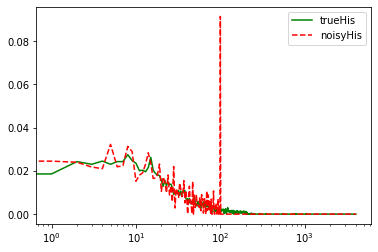

In [97]:
##Testing of algorithms for degree distribution
epsilon = 10.0
#noisyDegHis = nodeDP_nodeTrun_Smooth(G,maxDeg,epsilon,[200])
#noisyDegHis = nodeDP_flowgraph_degSeq_Lap(G,maxDeg,epsilon,[200])
noisyDegHis = nodeDP_edgeAdd_degCum_Lap(G,maxDeg,epsilon,[100])
print(trueHis[0:30])
print(noisyDegHis[0:30])
plotHis(trueHis/nodesNum,noisyDegHis/nodesNum)
print(difDegHis_L1(trueHis/nodesNum, noisyDegHis/nodesNum))
print(difDegHis_L1(trueHis/nodesNum, (np.zeros(maxDeg+1))/nodesNum))
print(difDegHis_L1(trueHis, noisyDegHis))
print(difDegHis_L1(trueHis, (np.zeros(maxDeg+1))))

In [11]:
###Evaluation of algorithms for degree distribution

algoNames = ["edgeDP_degHis_Lap", "edgeDP_degSeq_Lap", 
             "nodeDP_degHis_Lap", "nodeDP_degSeq_Lap", "nodeDP_nodeTrun_Smooth"]
algoKey = 4
algo = algoNames[algoKey]
print(algo)

#epsList = [0.01,0.02,0.05,0.1,0.2,0.5,1.0,2.0,5.0,10.0]
epsList = [0.01, 0.1, 1.0, 10.0]
#epsList = [10]
repeats = 10

for epsilon in epsList:
    errors = []
    for i in range(repeats):
        noisyDegHis = np.zeros(maxDeg+1)
        if algo == "edgeDP_degHis_Lap":        
            noisyDegHis = edgeDP_degHis_Lap(G,maxDeg,epsilon)
        elif algo == "edgeDP_degSeq_Lap":
            noisyDegHis = edgeDP_degSeq_Lap(G,maxDeg,epsilon)
        elif algo == "nodeDP_degHis_Lap":
            noisyDegHis = nodeDP_degHis_Lap(G,maxDeg,epsilon)
        elif algo == "nodeDP_degSeq_Lap":
            noisyDegHis = nodeDP_degSeq_Lap(G,maxDeg,epsilon)
        elif algo == "nodeDP_nodeTrun_Smooth":
            noisyDegHis = nodeDP_nodeTrun_Smooth(G,maxDeg,epsilon,[200])
        else:
            print("no valid algo")
        errors.append(difDegHis_L1(trueHis/nodesNum, noisyDegHis/nodesNum))
        #plotHis(trueHis/nodesNum,noisyDegHis/nodesNum)
        #plotCum(trueHis/nodesNum,noisyDegHis/nodesNum)
        
        
    print(epsilon, np.mean(errors))
    

nodeDP_nodeTrun_Smooth
0.01 1.5776182223322597
0.1 1.5952958653131954
1.0 1.6057580903347684
10.0 1.088844972682946


In [82]:
np.random.permutation(10)

array([0, 5, 6, 2, 4, 8, 3, 9, 7, 1])

In [89]:
print(getSortedDegSeq(G))

degSeqGt = np.zeros(nodesNum)
nodes = np.random.permutation(nodesNum)
for v in nodes:
    for u in G.neighbors(v):
        if u<v: #and degSeqGt[u]<theta and degSeqGt[v]<theta:
                #Gt.add_edge(u,v)
            degSeqGt[u] = degSeqGt[u]+1
            degSeqGt[v] = degSeqGt[v]+1

print(sorted(degSeqGt))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 